# PREDICTION DE LA REUSSITE SCOLAIRE

## 1. IMPORT DES LIBRAIRIES

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

## 2. CHARGEMENT DES DONNÉES

In [28]:
# Chargement des jeux de données
df_mat = pd.read_csv('../sources/student/student-mat.csv', sep=';')
df_por = pd.read_csv('../sources/student/student-por.csv', sep=';')

print("Dimensions Etudiants Math :", df_mat.shape)
print("Dimensions Etudiants Portugais :", df_por.shape)

# Affichage des premières lignes
display(df_mat.head())

Dimensions Etudiants Math : (395, 33)
Dimensions Etudiants Portugais : (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## 3. EXPLORATION DES DONNÉES

In [29]:
# Vérification des valeurs manquantes
print("Valeurs manquantes (Math) :", df_mat.isnull().sum().sum())
print("Valeurs manquantes (Portugais) :", df_por.isnull().sum().sum())

Valeurs manquantes (Math) : 0
Valeurs manquantes (Portugais) : 0


### Distribution de la variable cible (G3)

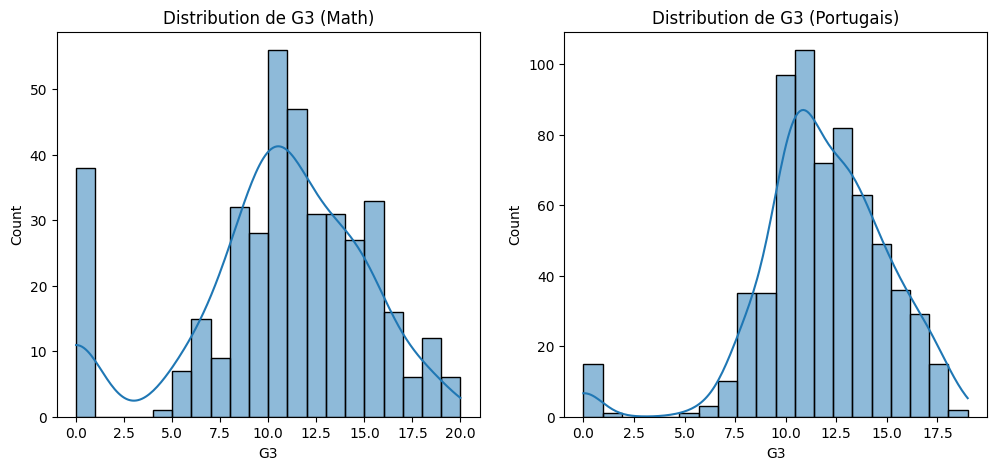

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_mat['G3'], kde=True, bins=20)
plt.title('Distribution de G3 (Math)')

plt.subplot(1, 2, 2)
sns.histplot(df_por['G3'], kde=True, bins=20)
plt.title('Distribution de G3 (Portugais)')
plt.show()

## 4. VISUALISATIONS & ANALYSE

### Matrice de Corrélation

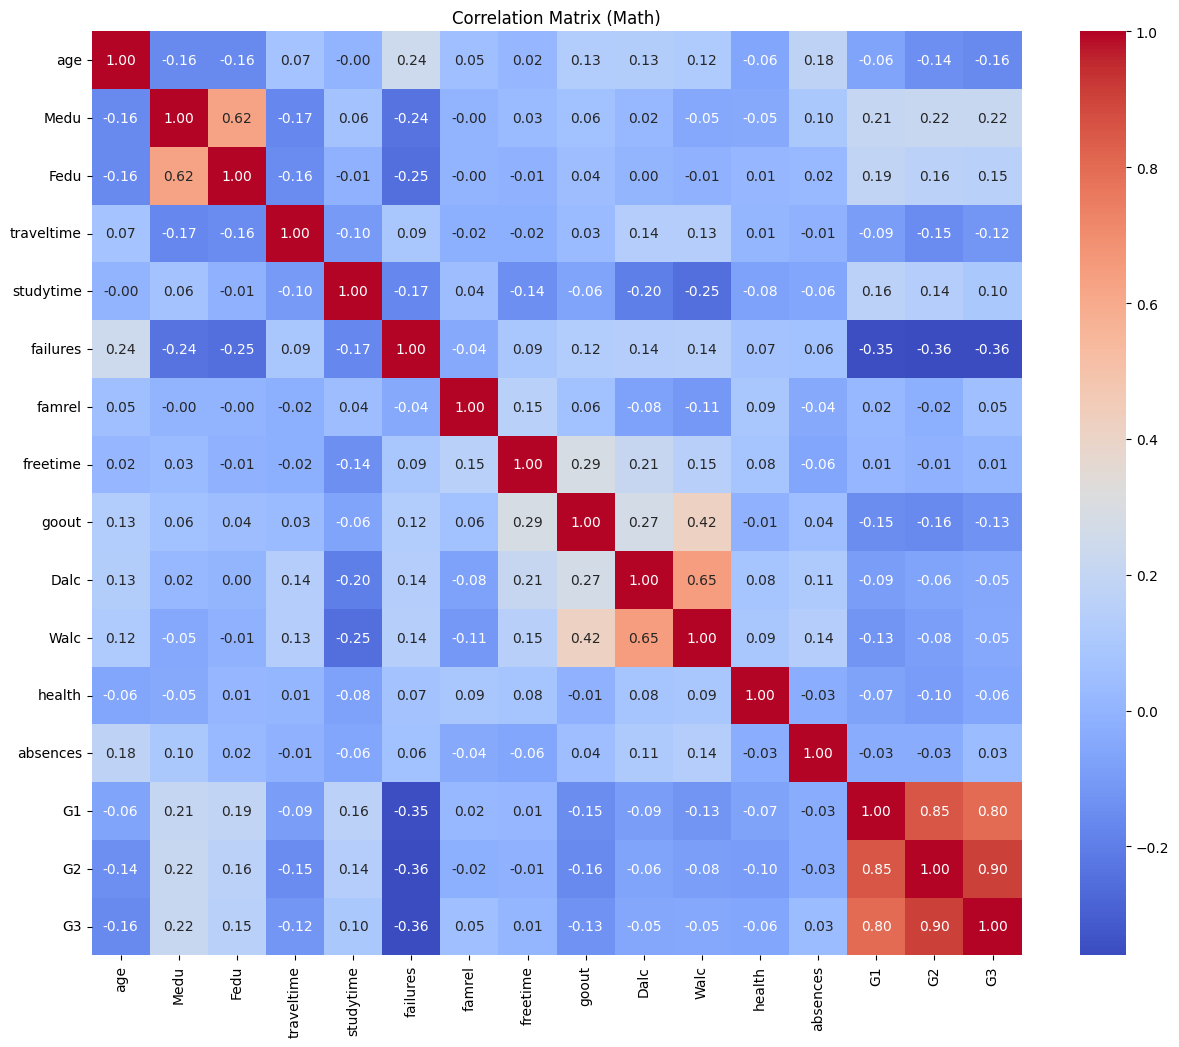

Top Correlations with G3 (Math):
G3            1.000000
G2            0.904868
G1            0.801468
Medu          0.217147
Fedu          0.152457
studytime     0.097820
famrel        0.051363
absences      0.034247
freetime      0.011307
Walc         -0.051939
Dalc         -0.054660
health       -0.061335
traveltime   -0.117142
goout        -0.132791
age          -0.161579
failures     -0.360415
Name: G3, dtype: float64


In [31]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_mat.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Math)')
plt.show()

# Display top correlations with G3
print("Top Correlations with G3 (Math):")
print(df_mat.select_dtypes(include=np.number).corr()['G3'].sort_values(ascending=False))

## 5.MODÉLISATION
### Preprocessing

## Note sur la Sélection du Modèle

Pour une analyse comparative détaillée et rigoureuse des différents algorithmes (Linear Regression, Random Forest, LightGBM, SVR, etc.), veuillez consulter le notebook dédié : [model_benchmarking.ipynb](https://github.com/crapougnax/simplon-final/blob/main/notebooks/model_benchmarking.ipynb).

Ce notebook séparé contient l'audit complet, incluant la validation croisée et l'analyse des métriques de performance qui ont conduit au choix du modèle utilisé ci-dessous.

--- Scénario 1 : Prédiction Finale (avec G1, G2) ---

--- Traitement Math Complet ---
Utilisation de toutes les fonctionnalités (y compris G1, G2)
Forme des caractéristiques : (395, 32)
Linear Regression: RMSE = 2.378, R2 = 0.724
Random Forest: RMSE = 1.958, R2 = 0.813


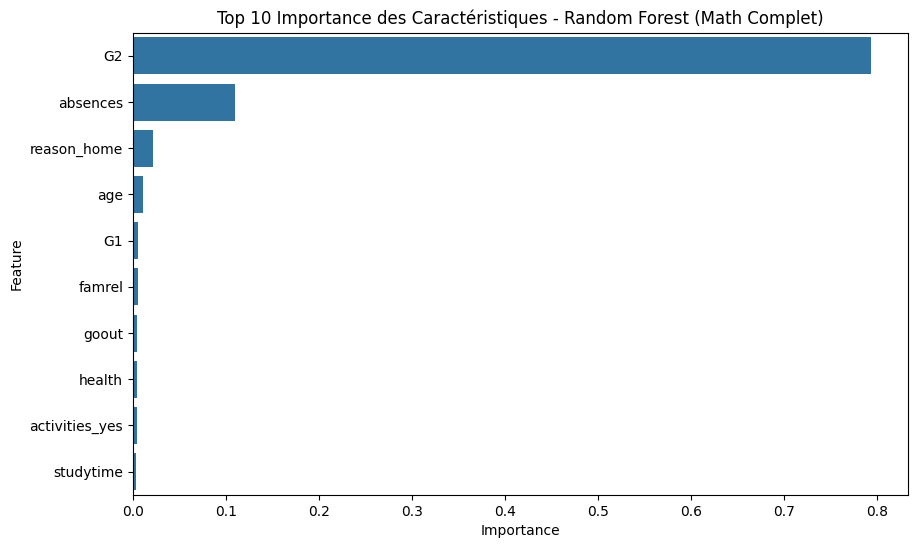


--- Traitement Portugais Complet ---
Utilisation de toutes les fonctionnalités (y compris G1, G2)
Forme des caractéristiques : (649, 32)
Linear Regression: RMSE = 1.215, R2 = 0.849
Random Forest: RMSE = 1.243, R2 = 0.842


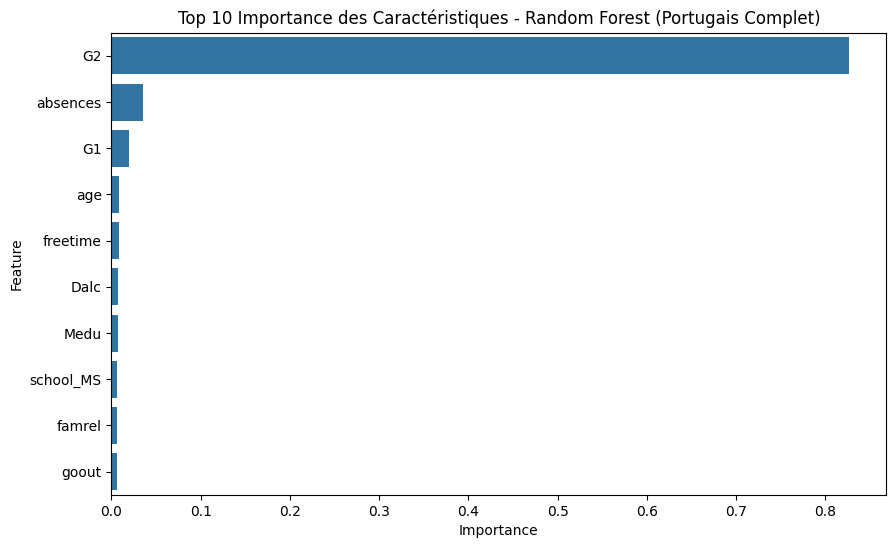


--- Scenario 2: Prédiction précoce (sans G1, G2) ---

--- Traitement Math précoce ---
Colonnes supprimées : ['G1', 'G2']
Forme des caractéristiques : (395, 30)
Linear Regression: RMSE = 4.196, R2 = 0.141
Random Forest: RMSE = 3.943, R2 = 0.242


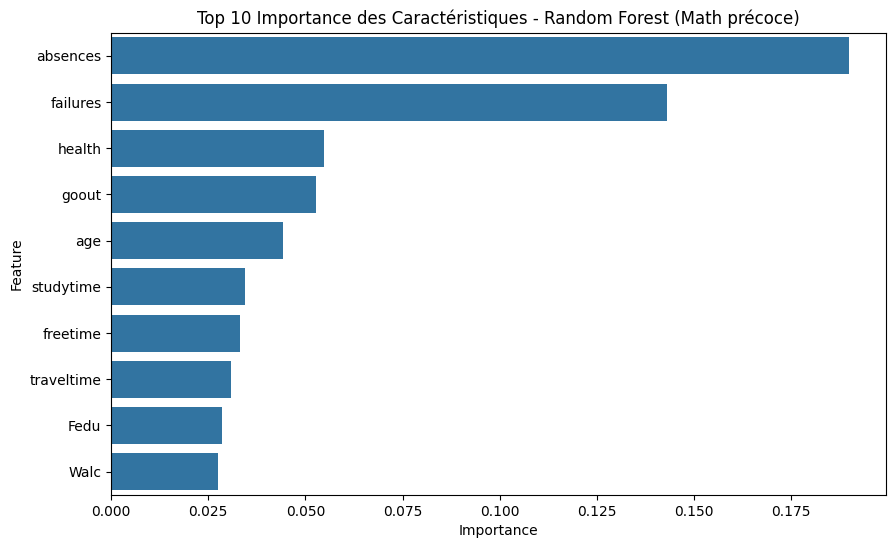


--- Traitement Portugais précoce ---
Colonnes supprimées : ['G1', 'G2']
Forme des caractéristiques : (649, 30)
Linear Regression: RMSE = 2.862, R2 = 0.160
Random Forest: RMSE = 2.838, R2 = 0.174


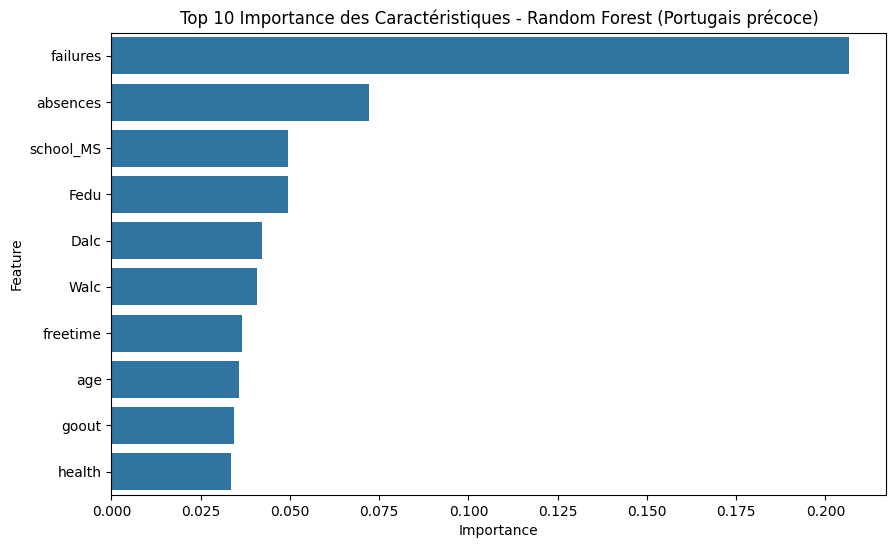

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def train_evaluate(df, subject_name, drop_cols=None):
    print(f"\n--- Traitement {subject_name} ---")
    
    target = 'G3'
    if drop_cols:
        X = df.drop(drop_cols + [target], axis=1)
        print(f"Colonnes supprimées : {drop_cols}")
    else:
        X = df.drop(target, axis=1)
        print("Utilisation de toutes les fonctionnalités (y compris G1, G2)")
        
    y = df[target]
    
    print("Forme des caractéristiques :", X.shape)
    
    # Categorical and Numerical features
    cat_features = X.select_dtypes(include=['object']).columns
    num_features = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Preprocessing Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
        ])
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define Models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Create Pipeline
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', model)])
        
        # Train
        clf.fit(X_train, y_train)
        
        # Predict
        y_pred = clf.predict(X_test)
        
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {'RMSE': rmse, 'R2': r2, 'Model': clf}
        print(f"{name}: RMSE = {rmse:.3f}, R2 = {r2:.3f}")
        
        # Feature Importance (Random Forest)
        if name == 'Random Forest':
             # Get feature names after one-hot encoding
            ohe_feature_names = clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_features)
            feature_names = np.r_[num_features, ohe_feature_names]
            importances = clf.named_steps['regressor'].feature_importances_
            
            # Create DataFrame for plotting
            feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
            feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(10)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feat_imp)
            plt.title(f'Top 10 Importance des Caractéristiques - Random Forest ({subject_name})')
            plt.show()
    
    return results

print("--- Scénario 1 : Prédiction Finale (avec G1, G2) ---")
# Math
results_mat_full = train_evaluate(df_mat, "Math Complet")

# Portugais
results_por_full = train_evaluate(df_por, "Portugais Complet")

print("\n--- Scenario 2: Prédiction précoce (sans G1, G2) ---")

# Math
results_mat_early = train_evaluate(df_mat, "Math précoce", drop_cols=['G1', 'G2'])

# Portugais
results_por_early = train_evaluate(df_por, "Portugais précoce", drop_cols=['G1', 'G2'])

## 6. FUSION DES JEUX DE DONNÉES ET COMPARAISON

Nombre d'étudiants dans les deux cours : 382

Corrélation entre G3 Math et G3 Portugais :
          G3_mat    G3_por
G3_mat  1.000000  0.480349
G3_por  0.480349  1.000000


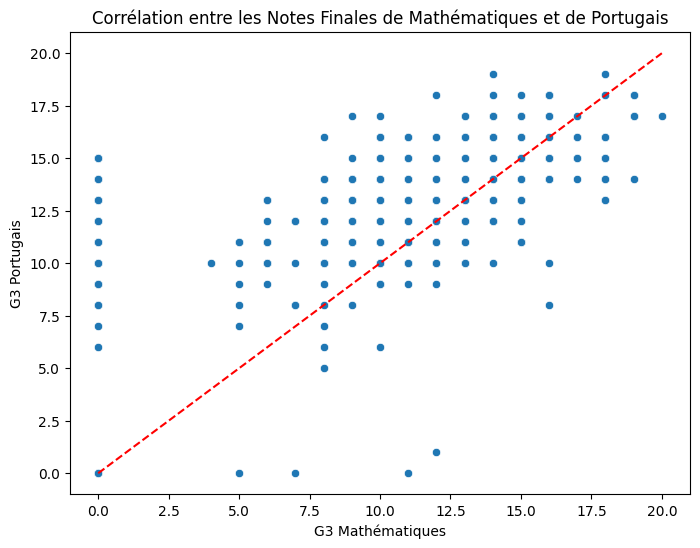

In [33]:
merge_cols = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]
df_merge = pd.merge(df_mat, df_por, on=merge_cols, suffixes=('_mat', '_por'))

print(f"Nombre d'étudiants dans les deux cours : {df_merge.shape[0]}")

# Correlation entre notes de Math et de Portugais
grade_corr = df_merge[['G3_mat', 'G3_por']].corr()
print("\nCorrélation entre G3 Math et G3 Portugais :")
print(grade_corr)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='G3_mat', y='G3_por', data=df_merge)
plt.title('Corrélation entre les Notes Finales de Mathématiques et de Portugais')
plt.xlabel('G3 Mathématiques')
plt.ylabel('G3 Portugais')
plt.plot([0, 20], [0, 20], 'r--') # Reference line y=x
plt.show()

## 7. FEATURE ENGINEERING

### Justification RGPD & Minimisation des Données

Dans le cadre de notre conformité au **RGPD**, nous avons appliqué un principe de **Minimisation des Données** pour les variables sensibles ci-dessous :

1.  **`TotalAlc` (Consommation d'Alcool)** : Nous agrégeons la consommation semaine/weekend en un score global (1-10). Cela permet de **réduire la granularité** de cette donnée sensible (santé/habitudes de vie) tout en conservant son pouvoir prédictif pour la lutte contre l'échec scolaire (finalité légitime).
2.  **`ParentEdu` (Éducation)** : Agrégée pour refléter le contexte familial global sans cibler un parent spécifique.
3.  **`HasFailed` (Échec)** : Binarisée (Oui/Non) pour éviter de stigmatiser le nombre exact de redoublements tout en identifiant le besoin de soutien.

Ces transformations permettent d'améliorer la performance du modèle tout en respectant la vie privée des étudiants (Pseudonymisation & Minimisation).

Nouvelles caractéristiques créées : TotalAlc, ParentEdu, HasFailed

--- Réévaluation de la Prédiction Précoce avec Ingénierie des Fonctionnalités ---

--- Traitement Math FE ---
Colonnes supprimées : ['G1', 'G2']
Forme des caractéristiques : (395, 33)
Linear Regression: RMSE = 4.127, R2 = 0.169
Random Forest: RMSE = 3.899, R2 = 0.259


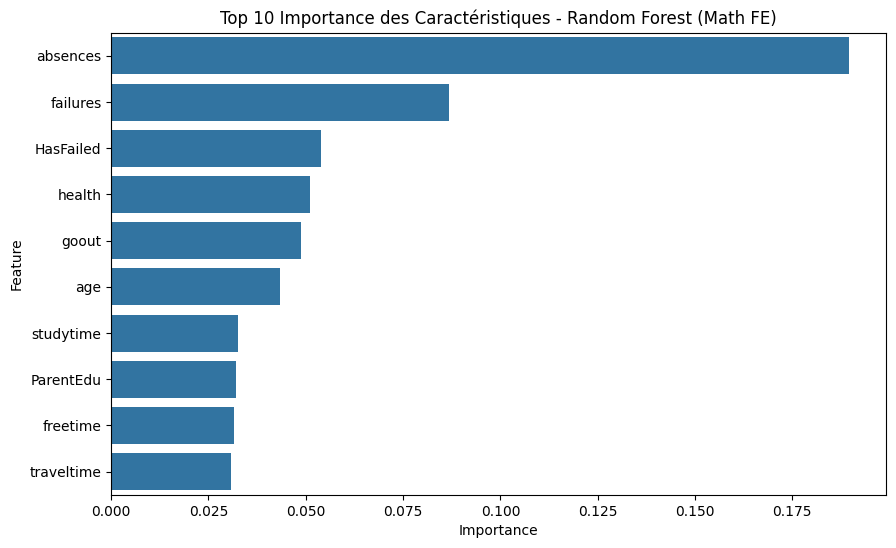


--- Traitement Portuguese FE ---
Colonnes supprimées : ['G1', 'G2']
Forme des caractéristiques : (649, 33)
Linear Regression: RMSE = 2.824, R2 = 0.182
Random Forest: RMSE = 2.893, R2 = 0.142


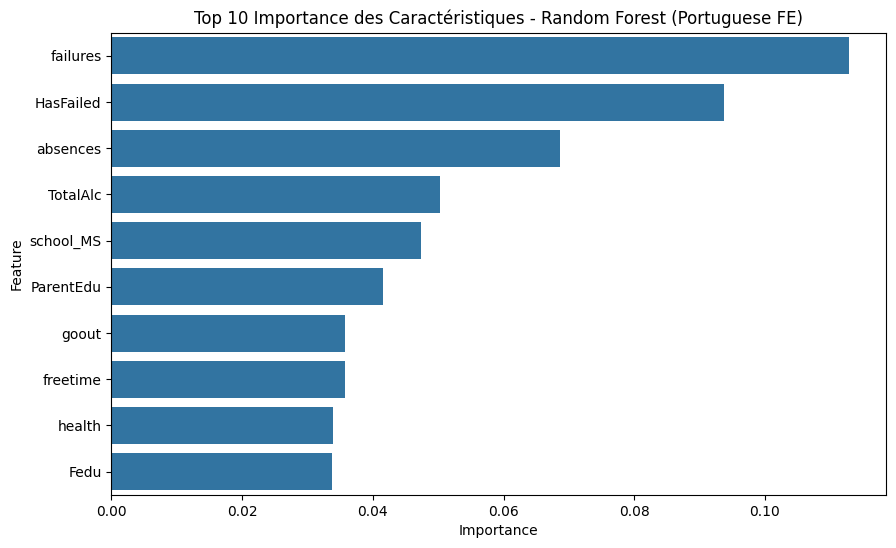

In [ ]:
def create_features(df):
    df = df.copy()
    # Total Alcohol Consumption
    df['TotalAlc'] = df['Dalc'] + df['Walc']
    
    # Parental Education Score
    df['ParentEdu'] = df['Medu'] + df['Fedu']
    
    # Failed at least once
    df['HasFailed'] = df['failures'].apply(lambda x: 1 if x > 0 else 0)
    
    # Study Time is already ordinal 1-4, maybe keep as is or bin if needed.
    return df

# Apply to datasets
df_mat_fe = create_features(df_mat)
df_por_fe = create_features(df_por)

print("Nouvelles caractéristiques créées : TotalAlc, ParentEdu, HasFailed")

print("\n--- Réévaluation de la Prédiction Précoce avec Ingénierie des Fonctionnalités ---")
# Run for Math
results_mat_fe = train_evaluate(df_mat_fe, "Math FE", drop_cols=['G1', 'G2'])

# Run for Portugais
results_por_fe = train_evaluate(df_por_fe, "Portugais FE", drop_cols=['G1', 'G2'])

## 8. SCENARIO 3: MERGED DATASET


--- Scénario 3 : Intégration du Jeu de Données Fusionné (Prediction précoce) ---
Forme du Jeu de Données Combiné : (1044, 37)

--- Traitement Combiné Math+Por ---
Colonnes supprimées : ['G1', 'G2']
Forme des caractéristiques : (1044, 34)
Linear Regression: RMSE = 3.663, R2 = 0.132
Random Forest: RMSE = 3.426, R2 = 0.241


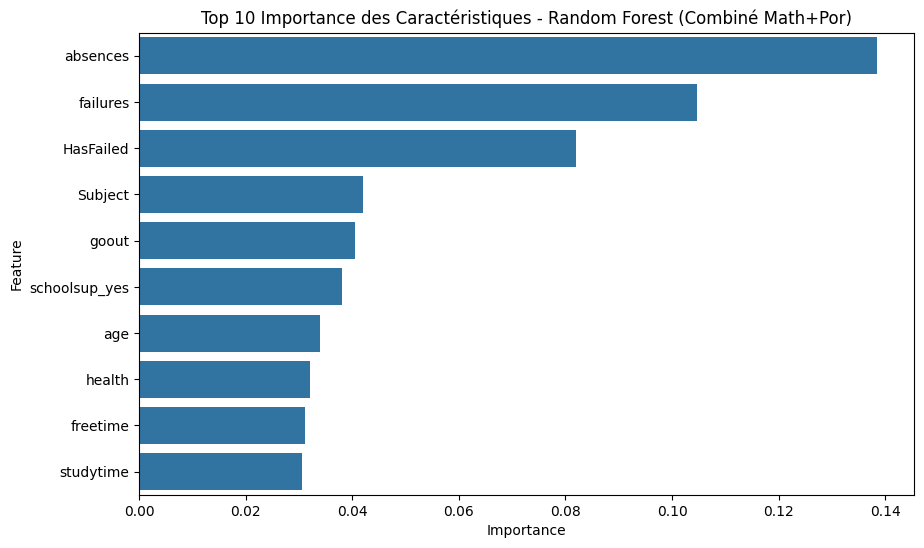

In [35]:
print("\n--- Scénario 3 : Intégration du Jeu de Données Fusionné (Prediction précoce) ---")
# Stack datasets (Concatenation, not Merge by student)
# We treat them as independent samples but add a 'Subject' attribute
df_mat_fe['Subject'] = 0 # 0 = Math
df_por_fe['Subject'] = 1 # 1 = Portugais

df_combined = pd.concat([df_mat_fe, df_por_fe], axis=0).reset_index(drop=True)

print(f"Forme du Jeu de Données Combiné : {df_combined.shape}")

# Entrainement sur le jeux de données combiné
results_combined = train_evaluate(df_combined, "Combiné Math+Por", drop_cols=['G1', 'G2'])

## 9. CONCLUSION & RECOMMANDATIONS
### Synthèse des Résultats
1. **Scénario 'Prédiction Finale' (Finale, avec notes)**: R2 > 0.8. Excellent modèle pour affiner la note.
2. **Scénario 'Prédiction Précoce' (Précoce, sans notes)**: R2 ~ 0.25 (Math), ~ 0.14 (Por). Prédiction difficile.

### Recommandations
- **Usage**: Utiliser le modèle 'Précoce' pour de la **détection**, pas de la prédiction fine.
- **Données**: Collecter plus d'historique (notes trimestres précédents même d'autres années) améliorerait la prédiction précoce.
- **Échec Scolaire & Déperdition**: Le problème d'échec scolaire est prégnant, visible par le nombre significatif d'élèves semblant avoir abandonné avant G3. Adresser cette cible devrait être la priorité, mais la granularité et l'historique des données actuelles limitent notre capacité à les identifier précocement avec certitude.